In [51]:
from lib.imports import *

In [52]:
skip_idx = [19,24,26,32,34,38,40,45,52,55,70]
all_idx = list(range(71))
for idx in skip_idx:
    all_idx.remove(idx)
import random
random.seed(0)
random.shuffle(all_idx)
k_folds = 5
foldi = 0
fold_size = int(len(all_idx)/k_folds)
test_idx = all_idx[foldi*fold_size:(foldi+1)*fold_size]
for idx in test_idx:
    all_idx.remove(idx)
train_idx = all_idx

In [54]:
window_size = 101
X,y = load_and_window_nursing_list(train_idx,window_size=window_size)

In [55]:
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=.05,stratify=y)
trainloader = DataLoader(TensorDataset(X_train,y_train),batch_size=64,shuffle=True)
devloader = DataLoader(TensorDataset(X_dev,y_dev),batch_size=64,shuffle=True)

In [56]:
device = 'cuda'
model = MLP(window_size=window_size).to(device=device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)

Params:  653501


100%|██████████| 10/10 [05:26<00:00, 32.64s/it]


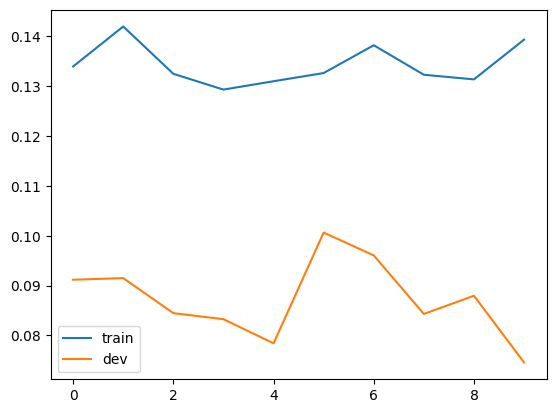

In [58]:
loss_tr = []
loss_dev = []
pbar = tqdm(range(10))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in trainloader:
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in devloader:
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))
plt.plot(loss_tr,label='train')
plt.plot(loss_dev,label='dev')
plt.legend()

tensor(0.7287, dtype=torch.float64)
tensor(0.1307, dtype=torch.float64)


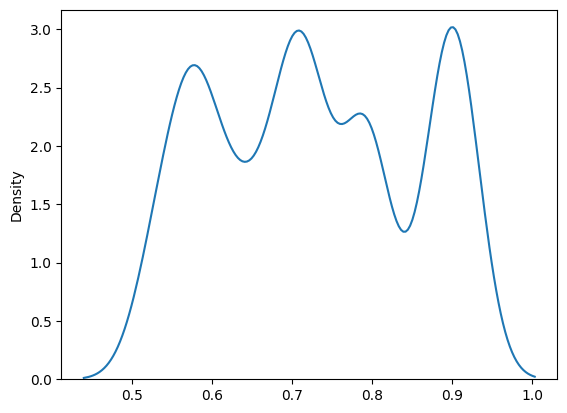

In [60]:
from sklearn.metrics import f1_score
f1i = []
for idx in test_idx:
    X,y = load_and_window_nursing_list([idx])
    y_pred = torch.sigmoid(model(X.cuda())).round().detach().cpu()
    f1i.append(f1_score(y_true=y,y_pred=y_pred,average='macro'))

sns.kdeplot(f1i,bw_adjust=.4)
print(torch.tensor(f1i).mean()) #.6653
print(torch.tensor(f1i).std()) #.1244